## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process : 11.234375
[[ 0.24365316  0.59030189 -0.76953025]
 [ 0.5475812   0.38804508 -0.74133383]
 [ 0.38812874  0.43343271 -0.81332169]
 ...
 [ 0.21891995  0.4656877  -0.8574433 ]
 [ 0.12505768  0.4956099  -0.85949485]
 [ 0.26142063  0.43508182 -0.86160494]]


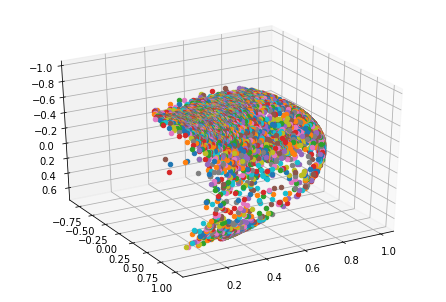

In [2]:
all_texts=[]
Y = []
dictionary= {}
start = time.process_time()
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//re8")
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process : "+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print("Number of documents: "+str(len(X)))
for j in range(len(X)):
    temp = ' '.join(map(str, X[j]))
    dictionary[temp]=Y[j]
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

Cluster purity measure indexes

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(chromsome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [18]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    
    Y_actual=[]
    Y_pred=[]
    for i in range(K):
        t=[]
        for j in range(len(clusters[i])):
            temp = ' '.join(map(str, clusters[i][j]))
            Y_actual.append(dictionary[temp])
            t.append(dictionary[temp])
        print(t)
        pred = statistics.mode(t)
        print(pred)
        for j in range(len(clusters[i])):
            Y_pred.append(pred)
            
    print(confusion_matrix(Y_actual, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [20]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#99ddff','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 11.480041026382068
Generation: 2 | Best fitness: 11.506471843594321
Generation: 3 | Best fitness: 11.50647184359433
Generation: 4 | Best fitness: 12.876287666554038
Generation: 5 | Best fitness: 14.062120403163593
Generation: 6 | Best fitness: 14.062120403163599
Generation: 7 | Best fitness: 9.575436503636851
Generation: 8 | Best fitness: 12.513229048790654
Generation: 9 | Best fitness: 11.738010113093967
Generation: 10 | Best fitness: 12.845755449404376
Generation: 11 | Best fitness: 11.70594886223963
Generation: 12 | Best fitness: 11.705948862239612
Generation: 13 | Best fitness: 11.290083470214466
Generation: 14 | Best fitness: 12.845755449404402
Generation: 15 | Best fitness: 13.5378104077609
Generation: 16 | Best fitness: 13.537810407760906
Generation: 17 | Best fitness: 11.444593019688796
Generation: 18 | Best fitness: 10.716837707535328
Generation: 19 | Best fitness: 12.845755449404441
Generation: 20 | Best fitness: 12.845755449404342
Generation: 21

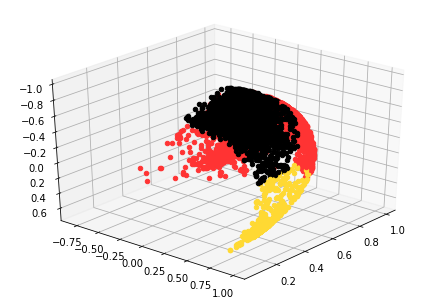

In [21]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 25.98929725489295
Generation: 2 | Best fitness: 27.75361425033499
Generation: 3 | Best fitness: 27.753614250334923
Generation: 4 | Best fitness: 26.60797997502023
Generation: 5 | Best fitness: 29.57009541820424
Generation: 6 | Best fitness: 29.570095418204303
Generation: 7 | Best fitness: 24.558078531189427
Generation: 8 | Best fitness: 24.558078531189384
Generation: 9 | Best fitness: 25.543635766255964
Generation: 10 | Best fitness: 23.126831337784417
Generation: 11 | Best fitness: 21.97219883325534
Generation: 12 | Best fitness: 23.762050181739422
Generation: 13 | Best fitness: 24.800468751360835
Generation: 14 | Best fitness: 26.167031131365594
Generation: 15 | Best fitness: 25.23548135826536
Generation: 16 | Best fitness: 26.613450529172898
Generation: 17 | Best fitness: 28.309942131862844
Generation: 18 | Best fitness: 24.815063789827914
Generation: 19 | Best fitness: 24.815063789827946
Generation: 20 | Best fitness: 24.35327575632186
Generation: 21 |

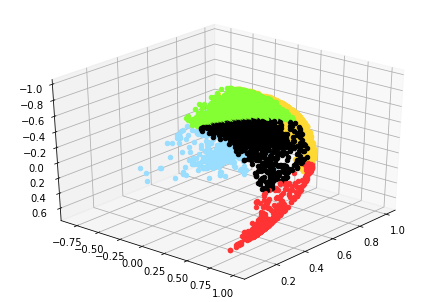

In [22]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 40.895471961751426
Generation: 2 | Best fitness: 45.859491620748074
Generation: 3 | Best fitness: 41.519346862667575
Generation: 4 | Best fitness: 44.300164421181975
Generation: 5 | Best fitness: 44.30016442118215
Generation: 6 | Best fitness: 40.061148213905945
Generation: 7 | Best fitness: 38.906324454006096
Generation: 8 | Best fitness: 47.458992889041866
Generation: 9 | Best fitness: 43.41595996523349
Generation: 10 | Best fitness: 41.85506477390134
Generation: 11 | Best fitness: 44.32117299957286
Generation: 12 | Best fitness: 41.15900566165177
Generation: 13 | Best fitness: 40.1310192656785
Generation: 14 | Best fitness: 40.13101926567882
Generation: 15 | Best fitness: 40.92679448548541
Generation: 16 | Best fitness: 40.9267944854854
Generation: 17 | Best fitness: 39.53767543158098
Generation: 18 | Best fitness: 43.50993163425122
Generation: 19 | Best fitness: 39.419396682266424
Generation: 20 | Best fitness: 40.56481006068723
Generation: 21 | Best f

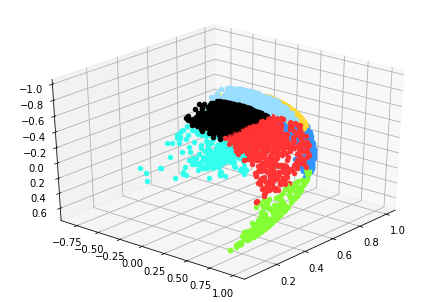

In [23]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 60.00258232819729
Generation: 2 | Best fitness: 61.70738841110192
Generation: 3 | Best fitness: 55.540094379000514
Generation: 4 | Best fitness: 57.01509348681006
Generation: 5 | Best fitness: 57.01509348680994
Generation: 6 | Best fitness: 66.27020879526317
Generation: 7 | Best fitness: 66.27020879526323
Generation: 8 | Best fitness: 59.407713365686355
Generation: 9 | Best fitness: 61.8356184443432
Generation: 10 | Best fitness: 60.245036070788785
Generation: 11 | Best fitness: 61.84197831380783
Generation: 12 | Best fitness: 62.2801462828299
Generation: 13 | Best fitness: 62.28014628282965
Generation: 14 | Best fitness: 78.78297491158304
Generation: 15 | Best fitness: 59.427321133411816
Generation: 16 | Best fitness: 59.26813688371312
Generation: 17 | Best fitness: 69.57543483956881
Generation: 18 | Best fitness: 63.41264744889742
Generation: 19 | Best fitness: 63.41264744889735
Generation: 20 | Best fitness: 64.13235419881828
Generation: 21 | Best fitne

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 92 | Best fitness: 50.808076715851136
Generation: 93 | Best fitness: 50.68632356001384
Generation: 94 | Best fitness: 50.82067635531108
Generation: 95 | Best fitness: 50.8057523383398
Generation: 96 | Best fitness: 50.73708419661744
Generation: 97 | Best fitness: 50.76848485049777
Generation: 98 | Best fitness: 50.721915778772974
Generation: 99 | Best fitness: 50.53924494585955
Generation: 100 | Best fitness: 50.31663242675775
Time taken: 11432.828125
DB Index        :0.7914566946064185
Silhoutte Index :0.9632259082780863
Calinski-Harabasz Index :30982.362204672674
1981
382
913
734
637
955
1264
221
587


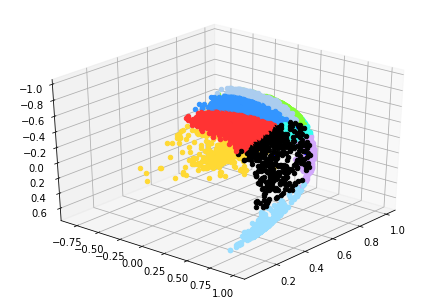

In [24]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)